<a href="https://colab.research.google.com/github/Nico14g/Proyecto_ML_Contaminacion_Curico/blob/main/Proyecto_MLContaminacion_Curico_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import IPython.core.display
import matplotlib ## paquete necesario para poder hacer gráficas

def apply_styles(): ### especificamos los parámetros para los gráficos
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles() ### finalmente aplicamos el estilo

In [78]:
### éstos elementos configuran fuente tamaño color de la letra porcentaje etc.
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [79]:
#importación de librerias
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

In [80]:
import warnings ## desactivan los mensajes para ciertos advertencias en las funciones
warnings.filterwarnings('ignore')

# 1.- Carga de datos

---


Los datos cargados corresponden a la contaminación atmosférica de la ciudad de Curicó desde el año 2013 hasta noviembre del año 2021


*   Se le da el parámetro sep como un ";" dado que como defecto viene como "," y esto afecta a que se carguen correctamente los datos.

*   También se le da el parámetro parse_dates, con el arreglo [1] correspondiente a la columna 1 del conjunto de datos, llamada *hora* para luego transformarla a una fecha.

*   Finalmente se le pasa el parámetro decimal como ",", debido a que los decimales en el archivo CSV son ",".



In [81]:
import pandas as pd
from datetime import datetime

url="https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
df = pd.read_csv(url, sep=';', header=None, skiprows=1, skip_blank_lines = True, parse_dates=[1], decimal=',', names=['fecha', 'hora', 'registrosValidados', 'registrosPreliminares', 'registrosNoValidados', 'NA' ])

df.head(5)

,fecha,hora,registrosValidados,registrosPreliminares,registrosNoValidados,NA
0,120707,0100,NaN,NaN,NaN,NaN
1,120707,0200,NaN,NaN,NaN,NaN
2,120707,0300,NaN,NaN,NaN,NaN
3,120707,0400,NaN,NaN,NaN,NaN
4,120707,0500,NaN,NaN,NaN,NaN


# 2.- Limpieza de datos


---

A continuación se presentan los pasos para limpiar el conjunto de datos y poder predecir la calidad del aire para la ciudad de Curicó.
Primero, se une la fecha y horas del conjunto de datos y posteriormente se transforma a al tipo de dato fecha.

In [82]:
df["fecha_hora"] = df["fecha"].astype(str)+ " " +df["hora"]
df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], yearfirst=True, format='%y%m%d %H%M') 

Se eliminan las columnas que ya no se utilizarán



In [83]:
df.drop(['fecha','hora','NA'], axis=1, inplace=True)

Se obtiene un resumen de los datos que quedaron en el conjunto de datos luego de unir la fecha y hora.

In [84]:
df.describe(datetime_is_numeric=True)

,registrosValidados,registrosPreliminares,registrosNoValidados,fecha_hora
count,57743.000000,16484.000000,2743.000000,82415
mean,26.576942,24.837794,173.897907,2017-03-19 23:59:59.999996416
min,1.000000,1.000000,-9.276490,2012-07-07 01:00:00
25%,8.000000,9.000000,8.090000,2014-11-12 12:30:00
50%,14.180000,14.000000,26.970000,2017-03-20 00:00:00
75%,28.857050,25.000000,98.400000,2019-07-26 11:30:00
max,612.000000,500.000000,1000.000000,2021-11-30 23:00:00
std,38.592488,34.566945,330.481939,NaN


Dado que los datos contenidos en la columna de registrosNoValidados se aleja demasiado de los registrosValidados y registroPrelimilares, se considera a primera vista descartarlos. Como se pudo ver en la tabla anterior el promedio excede bastante a las otras dos columnas, para ver mejor el comportamiento de los datos se puede apreciar el siguiente gráfico.

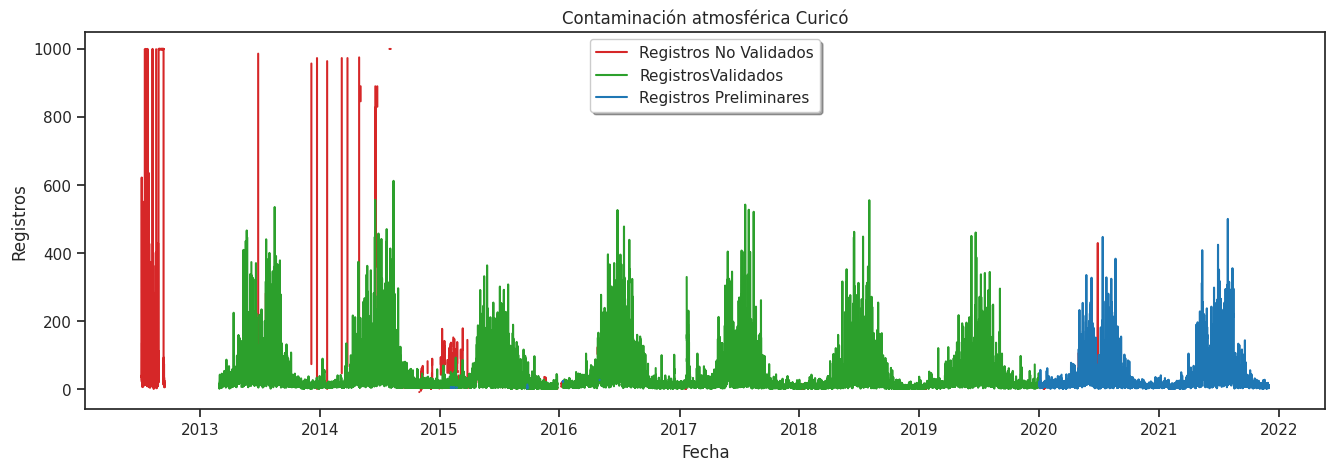

In [85]:

import matplotlib.pyplot as plt

def plot_df(df, x, y, z, w, title="", xlabel='Fecha', ylabel='Registros', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red', label="Registros No Validados")
    plt.plot(x, z, color='tab:green', label="RegistrosValidados")
    plt.plot(x, w, color='tab:blue', label="Registros Preliminares")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    legend = plt.legend(loc='upper center', shadow=True)
    plt.show()

plot_df(df, x=df.fecha_hora, y=df.registrosNoValidados, z=df.registrosValidados , w =df.registrosPreliminares, title='Contaminación atmosférica Curicó') 

Al inspeccionar de forma aislada los Registros No Validados, se puede apreciar que en gran parte estos datos no coinciden con los registros validados o preliminares, sin embargo, este comportamiento se mantiene hasta alrededor de los meses de abril o mayo del año 2015.

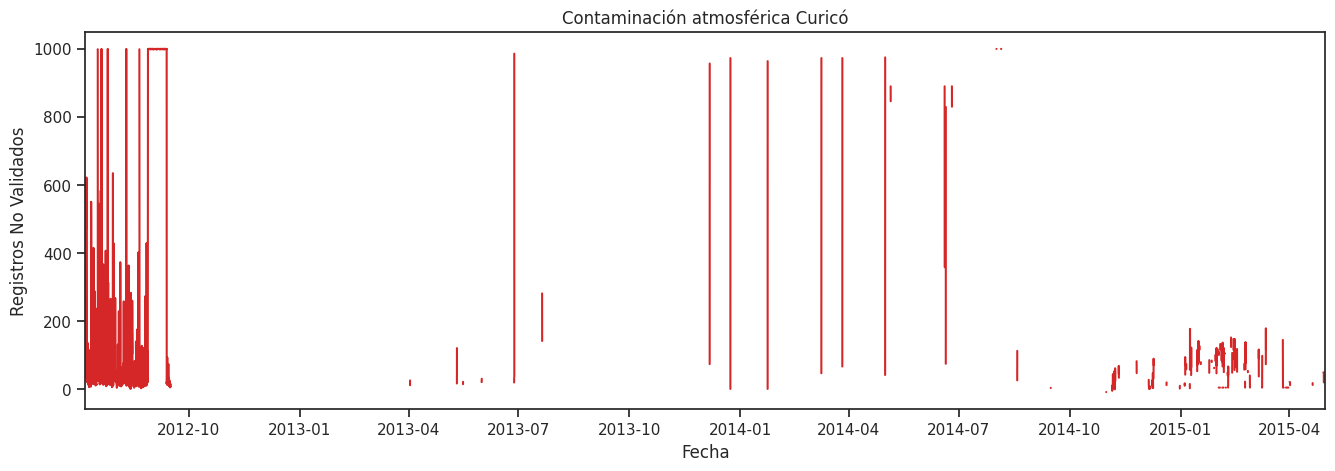

In [86]:


def plot_df2(df, x, y, title="", xlabel='Fecha', ylabel='Registros No Validados', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xlim([pd.to_datetime('2012-07-07 00:00:00'), pd.to_datetime('2015-05-01 00:00:00')])
    plt.show()

plot_df2(df, x=df.fecha_hora, y=df.registrosNoValidados, title='Contaminación atmosférica Curicó') 


Como se pudo apreciar en el gráfico anterior, la mayoría de los datos atípicos provistos por los registros no validados van desde el inicio de los datos, hasta mayo de 2015 por lo que se toma la decisión de juntar los datos no validados desde mayo de 2015 con los datos validados y preliminares.

In [87]:
import numpy as np
df.loc[df.fecha_hora < '2015-05-01 00:00:00', 'registrosNoValidados'] = np.nan


Dado que quedan datos atípicos como los menores a 1, estos también se reemplazan por valores faltantes.

In [88]:
df.loc[df.registrosNoValidados < 1, 'registrosNoValidados'] = np.nan

Al limpiar los registrosNoValidado, solo nos quedamos con un total de 740 de alrededor de 2000, sin embargo esto no provee un conjunto de datos más completo

In [89]:
df.describe(datetime_is_numeric=True)

,registrosValidados,registrosPreliminares,registrosNoValidados,fecha_hora
count,57743.000000,16484.000000,740.000000,82415
mean,26.576942,24.837794,20.630724,2017-03-19 23:59:59.999996416
min,1.000000,1.000000,1.000000,2012-07-07 01:00:00
25%,8.000000,9.000000,1.000000,2014-11-12 12:30:00
50%,14.180000,14.000000,3.376000,2017-03-20 00:00:00
75%,28.857050,25.000000,14.435000,2019-07-26 11:30:00
max,612.000000,500.000000,429.000000,2021-11-30 23:00:00
std,38.592488,34.566945,49.663202,NaN


Se combinan los registros Validados y Preliminares

In [90]:

df['registros'] = df['registrosValidados'].combine_first(df['registrosPreliminares'])
df['registros'] = df['registros'].combine_first(df['registrosNoValidados'])


Como filtramos anteriormente los registros no validados, ahora el la fecha de donde se considera comenzar es desde los registros validados, debido a que faltan bastantes datos entre que se comienzan a registrar los datos originales.

In [91]:
df.fecha_hora[df.registrosValidados.first_valid_index()]

Timestamp('2013-03-01 00:00:00')

La fecha correspondiente a los registros validados comienzan desde el 1 de marzo de 2013, por lo que se opta por comenzar a considerar el nuevo conjunto de datos desde esta fecha, además se cree que esto no afectará demasiado a la predicción posterior, debido a que se contará con alrededor de 8 años.

In [92]:

df = df[(df['fecha_hora'] > '2013-03-01')]  

Se eliminan las columnas que ya no son necesarias

In [93]:

df.drop(['registrosNoValidados','registrosValidados', 'registrosPreliminares'], axis=1, inplace=True)

In [94]:
df.describe(datetime_is_numeric=True)

,fecha_hora,registros
count,76727,74966.000000
mean,2017-07-16 11:59:59.999996416,26.136106
min,2013-03-01 01:00:00,1.000000
25%,2015-05-09 06:30:00,8.000000
50%,2017-07-16 12:00:00,14.000000
75%,2019-09-23 17:30:00,28.000000
max,2021-11-30 23:00:00,612.000000
std,NaN,37.882070


A continuación se muestra un gráfico con los datos filtrados, estos van desde el 1 de marzo de 2013 hasta el 30 de noviembre de 2021

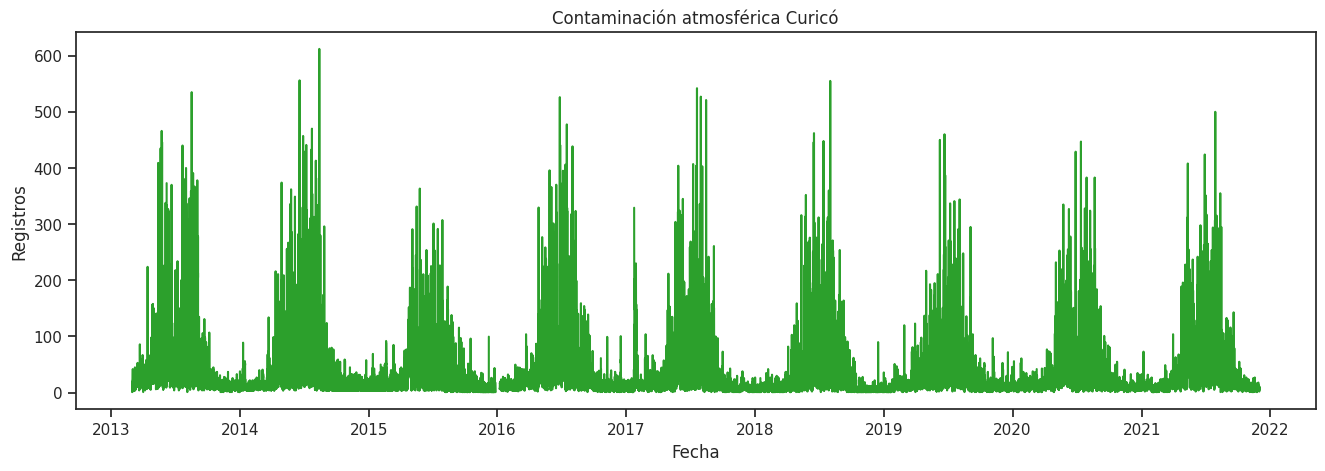

Timestamp('2021-11-30 23:00:00')

In [95]:


plt.figure(figsize=(16,5), dpi=100)
plt.plot(df.fecha_hora, df.registros, color='tab:green')
plt.gca().set(title="Contaminación atmosférica Curicó", xlabel="Fecha", ylabel="Registros")
plt.show()

df.fecha_hora[df.registros.last_valid_index()]

Como se puede apreciar los registros con datos faltantes son 1761, de un total de 76727 luego de haber filtrado los datos. Por otro lado, la columna perteneciente a la fecha no posee datos faltantes, asegurando la continuidad de la serie de tiempo.

In [96]:

df.isna().sum() 

fecha_hora       0
registros     1761
dtype: int64

# 3.- Datos Faltantes


---


Se toma la decisión de conservar los datos como están en lugar de eliminar instancias del conjunto de datos, debido a que podría afectar a la serie de tiempo. En lugar de eso, se procede a probar diferentes tipos de interpolación de datos.

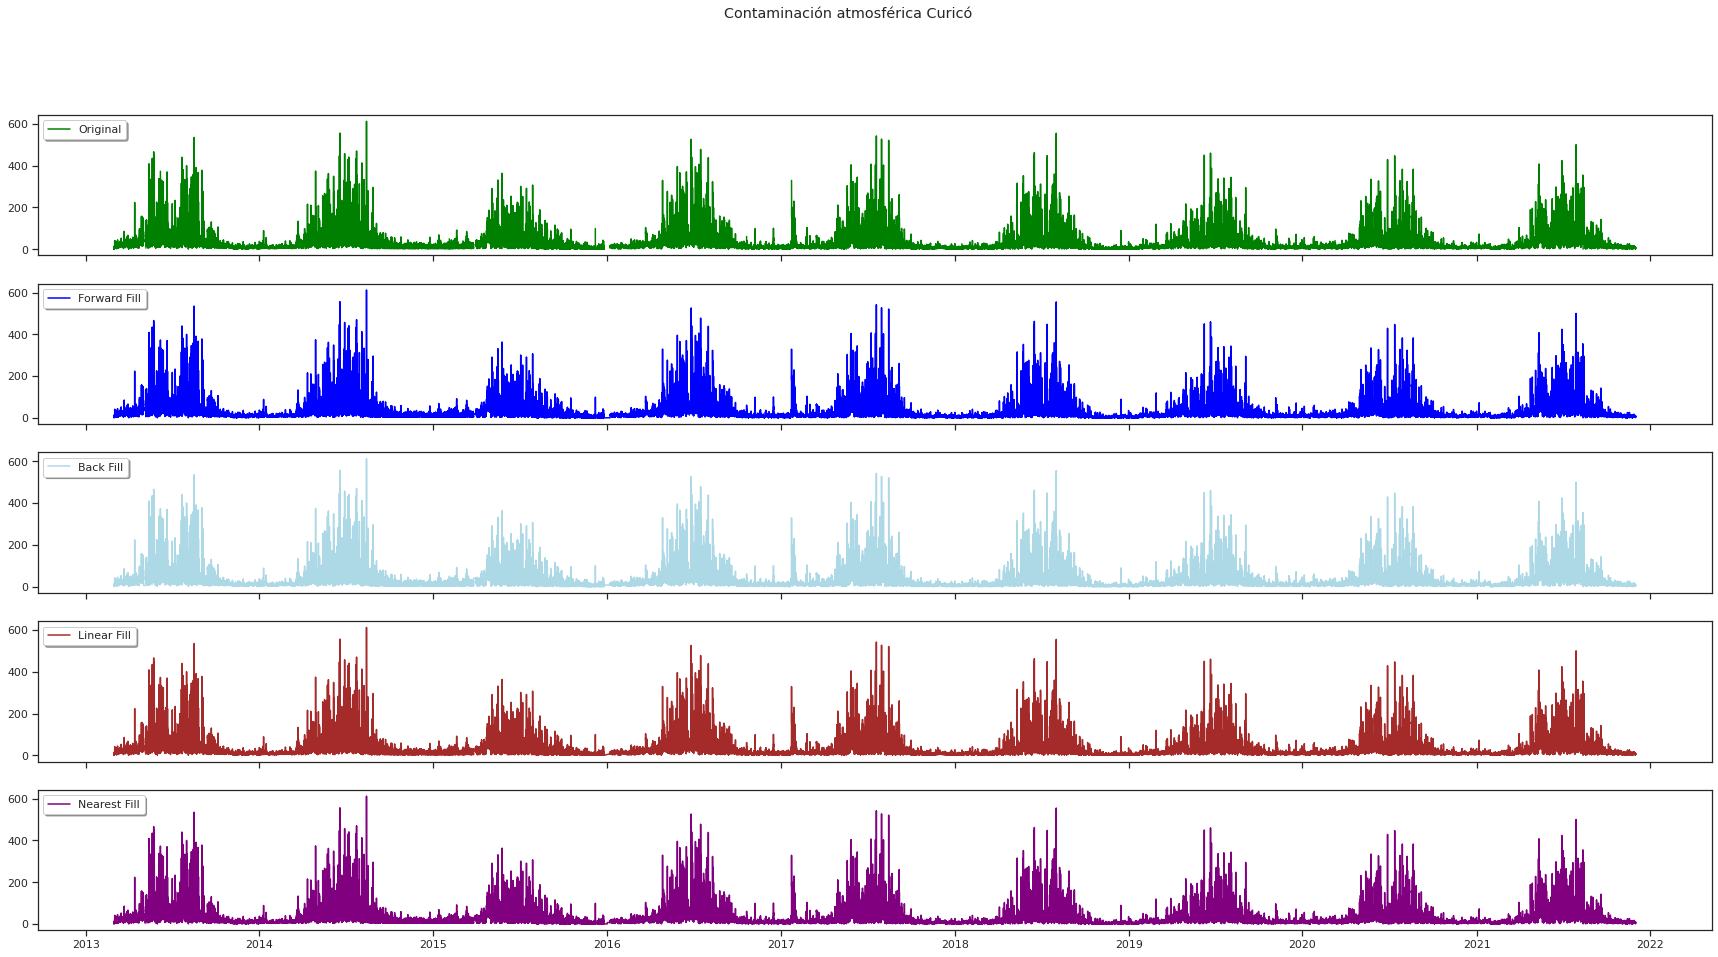

In [97]:


from scipy.interpolate import interp1d


fig, axs = plt.subplots(5, 1, sharex=True, figsize=(30, 15))
fig.suptitle('Contaminación atmosférica Curicó')

# ----------------------------- Dataset Original -----------------------------------
axs[0].plot(df.fecha_hora, df.registros, label='Original', color='green')
axs[0].legend(loc='upper left', shadow=True)


# ----------------------------- Método Forward Fill-----------------------------------
df_ffill = df.ffill()
axs[1].plot(df_ffill.fecha_hora, df_ffill.registros, label='Forward Fill', color='blue')
axs[1].legend(loc='upper left', shadow=True)

# -----------------------------Método Backward Fill -----------------------------------
df_bfill = df.bfill()
axs[2].plot(df_bfill.fecha_hora, df_bfill.registros, label='Back Fill', color='lightblue')
axs[2].legend(loc='upper left', shadow=True)


# -----------------------------Método Linear Fill-----------------------------------
df_linear = df.copy()
df_linear['registros'].interpolate(method='linear', inplace=True)
axs[3].plot(df_linear.fecha_hora, df_linear.registros, label='Linear Fill', color='brown')
axs[3].legend(loc='upper left', shadow=True)

# -----------------------------Método Nearest Fill-----------------------------------
df_nearest = df.copy()
df_nearest['registros'].interpolate(method='nearest', inplace=True)
axs[4].plot(df_nearest.fecha_hora, df_nearest.registros, label='Nearest Fill', color='purple')
axs[4].legend(loc='upper left', shadow=True)

De los gráficos obtenidos anteriormente con los métodos de interpolación, no se consigue apreciar de buena forma el que mejor se adapta para el caso, tampoco es posible obtener una medida de error debido a que no tenemos con que comparar los resultados de cada método, por lo que se opta por escoger el método nearest fill, ya que posiblemente tiene un mejor comportamiento en la fecha de inicios de el año 2016, en comparación a los demás métodos.


# 4.- Conjunto de entrenamiento y test


---



Al separar el conjunto de datos en 80% para entrenar y 20% para comprobar la predicción, se obtiene que los datos de entrenamiento llegan hasta julio de 2019, sin embargo los datos terminan el 30 de noviembre del año 2021, por lo que se opta por reajustar los conjuntos de entrenamiento hasta el 30 de noviembre del año 2019 y los de test hasta 30 de noviembre del año 2021, con el fin de poder predecir exactamente 2 años más adelante, con esto se cree que el modelo a generar no sobreentrenará ya que la diferencia son de 4 meses, en comparación al conjunto total de datos los cuales corresponden a aproximadamente 8 años.

In [98]:


p_train = 0.80 # Porcentaje de train.

train = df_nearest[:int((len(df_nearest))*p_train)] 
test = df_nearest[int((len(df_nearest))*p_train):]

print("Conjunto para entrenar: ", len(train))
print("Conjunto para test: ", len(test))

print("Fecha límite de datos de entrenamiento: ", df_nearest.fecha_hora[len(train)])

train = df_nearest[(df_nearest['fecha_hora'] <= '2019-11-30 23:00:00')]
test =  df_nearest[(df_nearest['fecha_hora'] > '2019-11-30 23:00:00')]


Conjunto para entrenar:  61381
Conjunto para test:  15346
Fecha límite de datos de entrenamiento:  2019-07-08 14:00:00


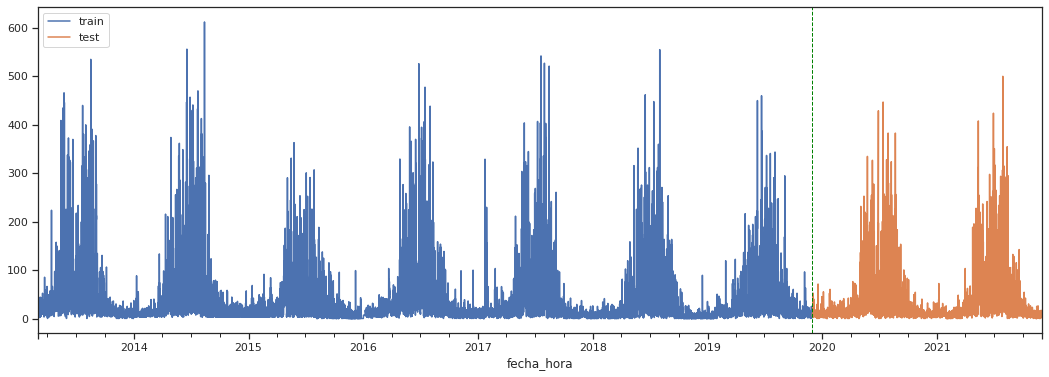

In [99]:
fig, ax = plt.subplots(figsize=(18,6))

train.plot(x="fecha_hora", y="registros", ax=ax, label="train")
test.plot(x="fecha_hora", y="registros", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(test.fecha_hora.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')


# 5.- Entrenamiento con Prophet


---

A continuación se procede a implementar la predicción de la calidad de aire para la ciudad de Curicó a través de Prophet.

In [100]:
from fbprophet import Prophet #importación de Prophet

df_prophet_train = train
df_prophet_train.columns = ["ds", "y"]

#Creación del modelo 
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    growth='linear')


In [101]:
#Entrenamiento del modelo
model.fit(df_prophet_train)

In [102]:
df_prophet_test = test
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])

yhat_test = forecast.yhat.values
y_test = df_prophet_test.y.values

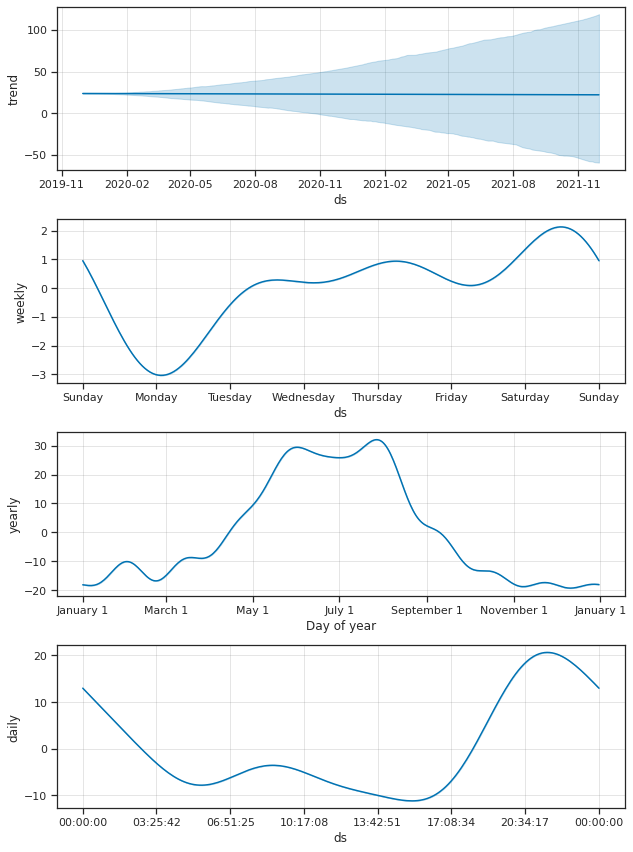

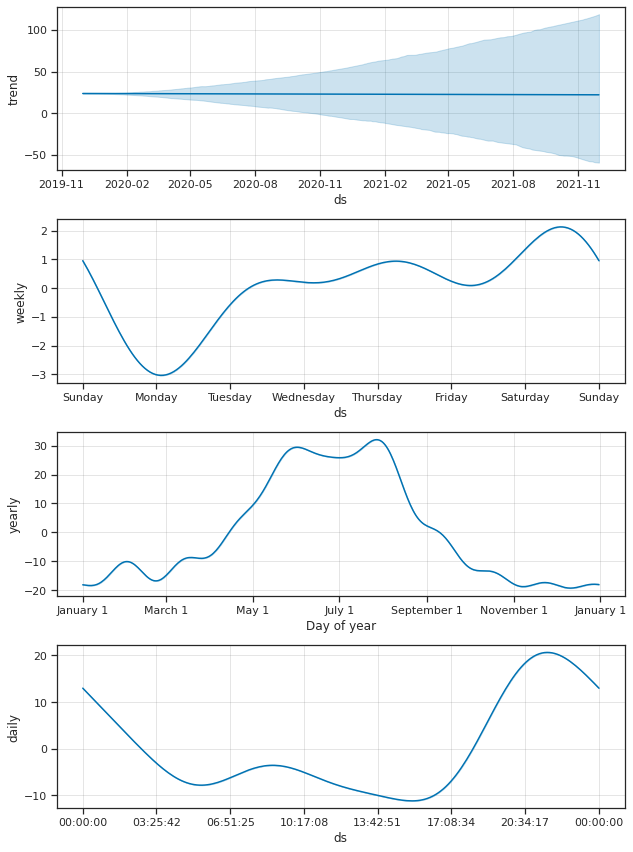

In [103]:
model.plot_components(forecast)

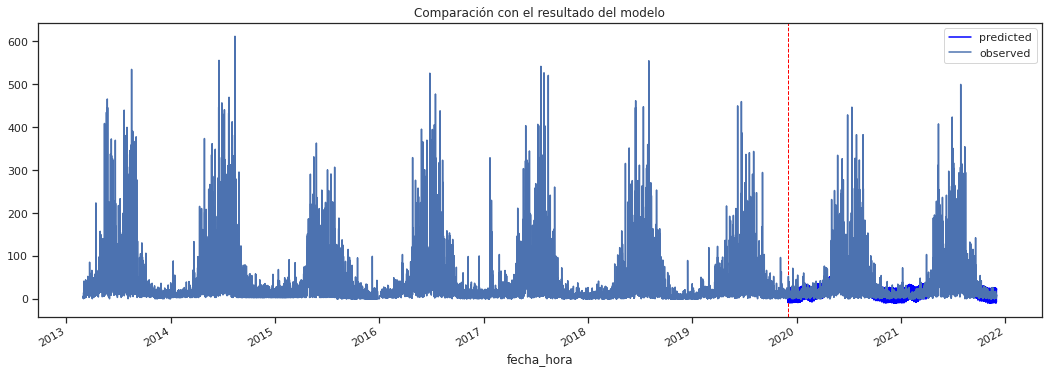

In [104]:
fig, ax = plt.subplots(figsize=(18,6))


plt.axvline(pd.to_datetime(str(test.ds.values[0])), c='red', ls='--', lw=1)
ax.plot(test.ds.values, yhat_test, color="blue", label="predicted")

df_nearest.plot(x="fecha_hora", y="registros", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Comparación con el resultado del modelo')

plt.show();

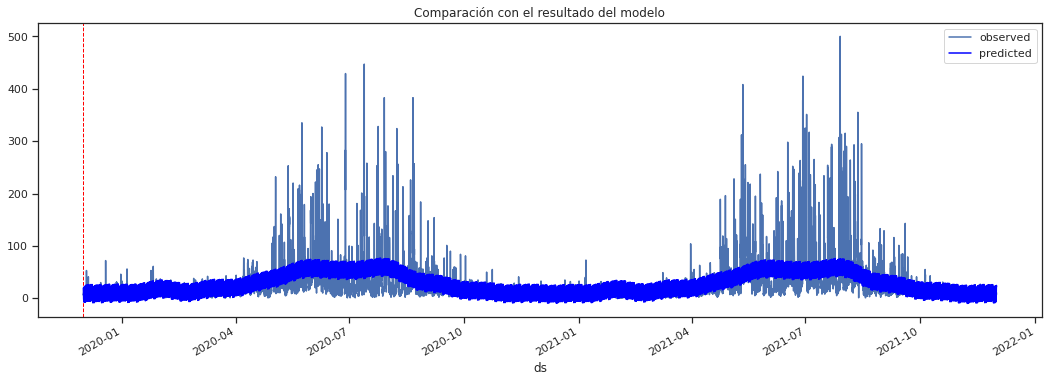

In [105]:
fig, ax = plt.subplots(figsize=(18,6))

plt.axvline(pd.to_datetime(str(test.ds.values[0])), c='red', ls='--', lw=1)

test.plot(x="ds", y="y", ax=ax, label="observed")
ax.plot(test.ds.values, yhat_test, color="blue", label="predicted")

plt.legend(loc='best')
plt.title('Comparación con el resultado del modelo')

plt.show();



El desempeño presentado en el modelo anterior, no es muy bueno, por lo que se procede a realizar el mismo experimento pero con el promedio diario de cada fecha.

In [106]:
mean_days = df_nearest.groupby(df_nearest['fecha_hora'].dt.strftime("%y%m%d")).mean().reset_index()
mean_days['fecha_hora'] = pd.to_datetime(mean_days['fecha_hora'], yearfirst=True, format='%y%m%d')

mean_train = mean_days[(mean_days['fecha_hora'] <= '2019-11-30')]
mean_test =  mean_days[(mean_days['fecha_hora'] > '2019-11-30')]


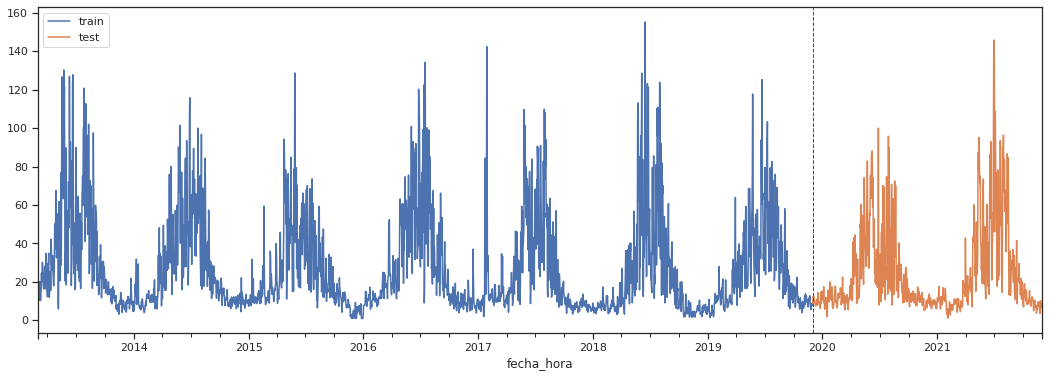

In [107]:
fig, ax = plt.subplots(figsize=(18,6))

mean_train.plot(x="fecha_hora", y="registros", ax=ax, label="train")
mean_test.plot(x="fecha_hora", y="registros", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(mean_test.fecha_hora.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

In [108]:
df_prophet_train = mean_train
df_prophet_train.columns = ["ds", "y"]

#Creación del modelo 
mean_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    growth='linear')


In [109]:
#Entrenamiento del modelo
mean_model.fit(df_prophet_train)

In [110]:
df_prophet_test = mean_test
df_prophet_test.columns = ["ds", "y"]

forecast = mean_model.predict(df_prophet_test[['ds']])

yhat_test = forecast.yhat.values
y_test = df_prophet_test.y.values

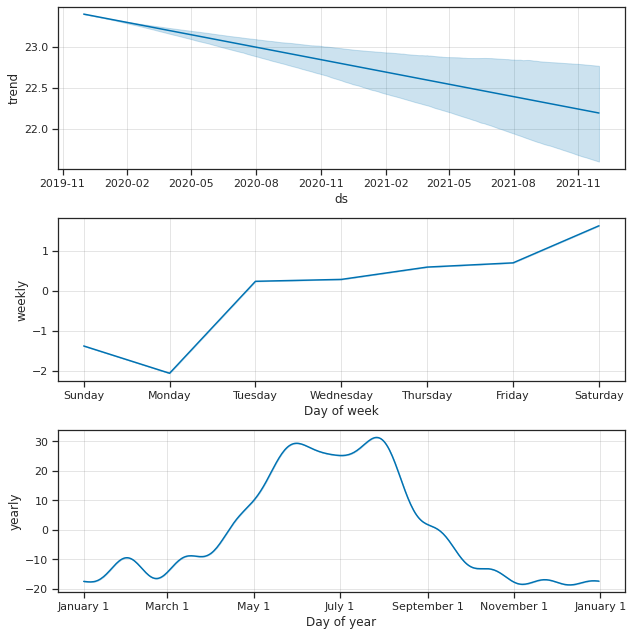

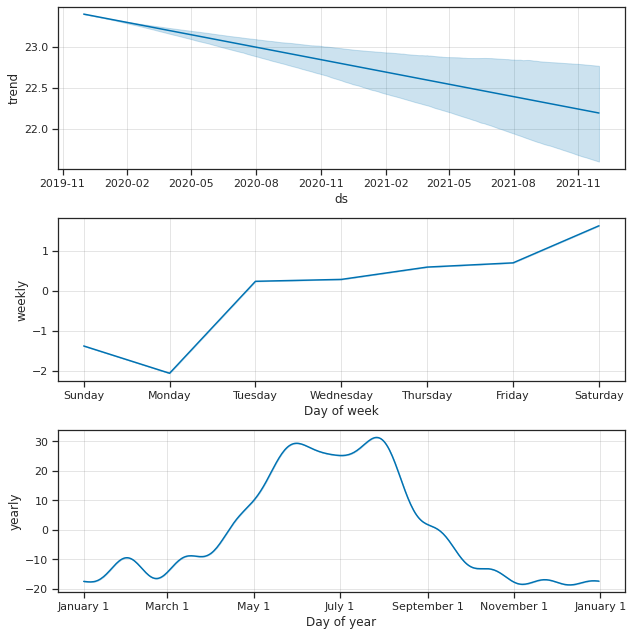

In [111]:
mean_model.plot_components(forecast)

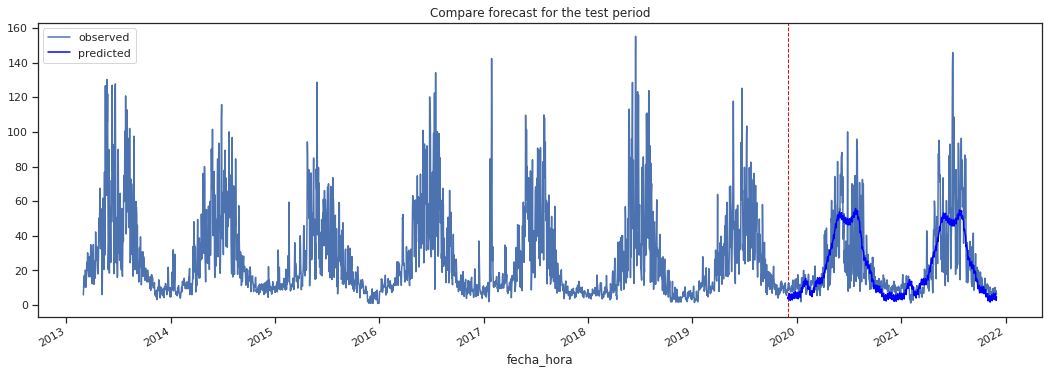

In [112]:
fig, ax = plt.subplots(figsize=(18,6))


plt.axvline(pd.to_datetime(str(mean_test.ds.values[0])), c='red', ls='--', lw=1)


mean_days.plot(x="fecha_hora", y="registros", ax=ax, label="observed")
ax.plot(mean_test.ds.values, yhat_test,
        color="blue", label="predicted")
plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.show();

# Conclusión


---

Como se pudo observar en el primer modelo, la predicción no estuvo muy acertada, sin embargo, se pueden extraer bastante información de los gráficos obtenidos.


*   A nivel anual se tiene que la mayor parte de la contaminación se produce entre los meses de mayo y septiembre, posiblemente debido al invierno.
*   A nivel mensual no se observa ninguna tendencia clara.
*   A nivel semanal, se obtiene que la menor concentración de contaminación atmosférica se da los días lunes, mientras que la mayor se da entre los días sábado y domingo.
*   Finalmente, a nivel diario, se puede observar que la mayor parte de la contaminación se da alrededor de las 21:00 horas, mientras que la menor contaminación se da pasado de las 15:00 horas.

Por otro lado, al momento de analizar el segundo modelo con el promedio diario de los datos, se obtienen casi las mismas conclusiones anteriores, siendo la principal diferencia encontrada que los niveles de contaminación ahora solo llegan hasta los 140 en lugar de los 612 del primer modelo, por lo que el modelo resultante logra adaptarse mejor en este caso. Sin embargo, al realizar este cambio se pierde información de la contaminación a nivel horario.

